In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from jax import jit
import jax.numpy as jnp
from ticktack import fitting, resample
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = (8.0, 6.0)
#from helper import run_resample, load_IntCal20
import pandas as pd
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import statistics

In [2]:
data = pd.read_csv("../data/Miyahara.csv")
## fake data!
data.d14c = np.random.randn(len(data.d14c))*data.sig_d14c

ndata = 1000
data = pd.DataFrame({'year':np.arange(ndata),
                     'd14c':np.random.randn(ndata),
                     'sig_d14c':np.ones(ndata)})

<ErrorbarContainer object of 3 artists>

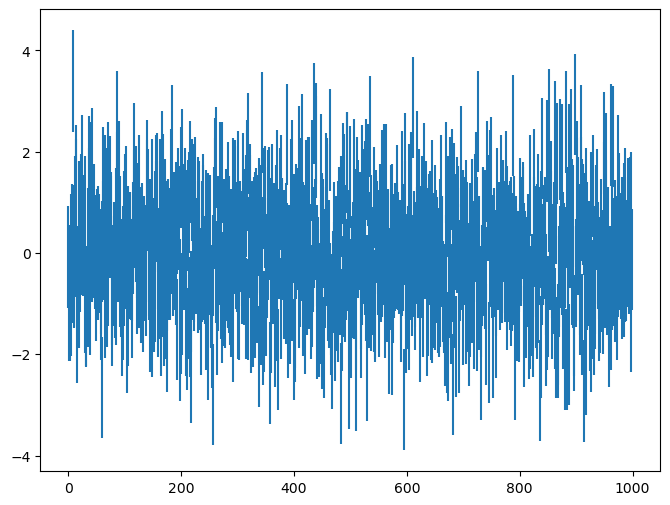

In [3]:
plt.errorbar(data.year, data.d14c, yerr=data.sig_d14c, linestyle='None')

In [4]:
class Resampler:

    def load_data(self, x, y, yerr):
        self.x = x
        self.y = y
        self.yerr = yerr
        self.start = np.nanmin(self.x)
        self.end = np.nanmax(self.x)
        self.annual = jnp.arange(self.start, self.end + 1)

    def super_gaussian(self, x, sz, order=30):
        return np.exp(-(x / sz) ** order)

    def bandpass_super_gaussian(self, signal, l, sz, order=30):
        if np.ndim(signal) == 1:
            signal = signal.reshape(1, -1)
        n = signal.shape[1]
        freq = fftfreq(n, d=1)
        mask = self.super_gaussian(np.abs(freq) - l, sz, order=order).reshape(1, -1)
        new_signal = ifft(fft(signal) * mask)
        return np.abs(np.squeeze(new_signal))

    def signal_resample(self, size=10000, l=1./9.677, sz=0.05, order=30, samples=None):
        if not np.all(samples):
            samples = np.random.multivariate_normal(self.y, np.diag(self.yerr ** 2), size=size)
        f = interp1d(self.x, samples, kind="cubic")
        interpolation = f(self.annual)
        new_sig = self.bandpass_super_gaussian(interpolation, l, sz, order=order)
        return new_sig



In [5]:
samples = np.random.multivariate_normal(resampler.y, np.diag(resampler.yerr ** 2), size=10000)
print(samples.shape)

NameError: name 'resampler' is not defined

(array([  1.,   1.,   2.,   4.,   9.,  22.,  21.,  24.,  43.,  69., 106.,
        100.,  92., 104., 107.,  92.,  66.,  45.,  37.,  21.,  17.,   8.,
          4.,   3.,   2.]),
 array([-4.94298106, -4.56815001, -4.19331896, -3.81848791, -3.44365686,
        -3.06882581, -2.69399476, -2.31916371, -1.94433266, -1.56950161,
        -1.19467056, -0.81983951, -0.44500846, -0.07017741,  0.30465364,
         0.67948469,  1.05431574,  1.42914679,  1.80397784,  2.17880889,
         2.55363994,  2.928471  ,  3.30330205,  3.6781331 ,  4.05296415,
         4.4277952 ]),
 <BarContainer object of 25 artists>)

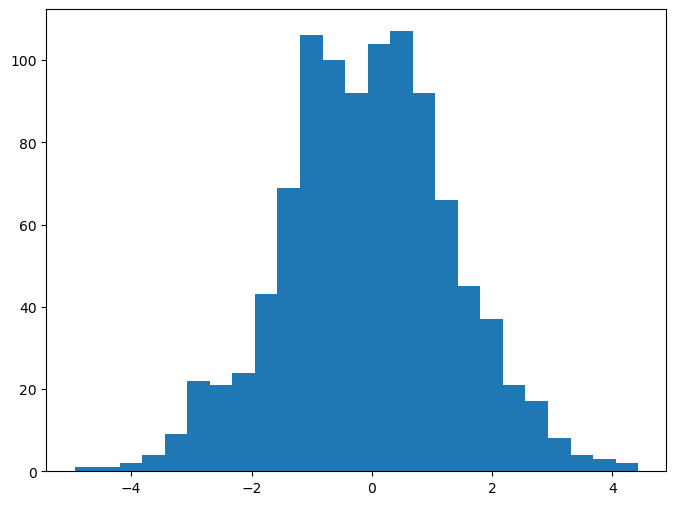

In [ ]:
plt.hist(resampler.y+np.random.randn(len(resampler.y)),bins=25)

In [ ]:
from scipy.fft import fft, ifft, fftfreq


In [ ]:
n = samples.shape[1]
freq = fftfreq(n, d=1)
mask = resampler.super_gaussian(np.abs(freq) - 1/9.677, 0.05, order=order).reshape(1, -1)
new_signal = ifft(fft(samples) * mask)



/tmp/ipykernel_2022/717336713.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,(fft(samples)).real.mean(axis=0))
/tmp/ipykernel_2022/717336713.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,(fft(samples)).real[0,:],color='C2')
/tmp/ipykernel_2022/717336713.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.fill_between(1/freq,- (fft(samples)).real.std(axis=0), (fft(samples)).real.std(axis=0),alpha=0.5)


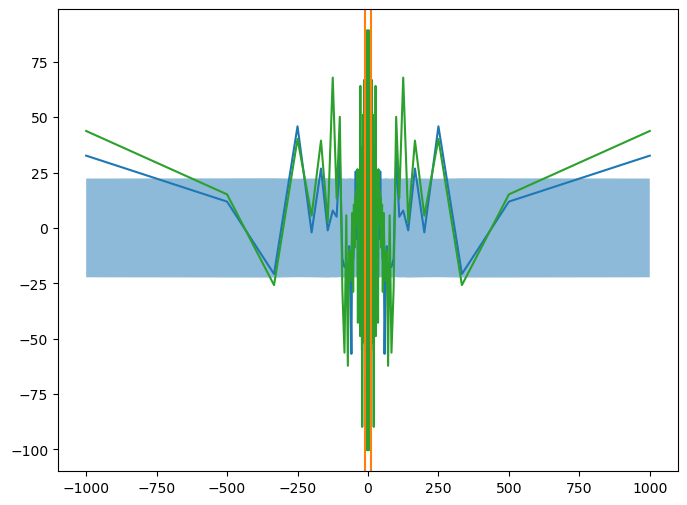

In [ ]:
plt.plot(1/freq,(fft(samples)).real.mean(axis=0))
plt.plot(1/freq,(fft(samples)).real[0,:],color='C2')
# plt.fill_between(1/freq,(fft(samples)*mask).real.mean(axis=0) - (fft(samples)*mask).real.std(axis=0),
#                  (fft(samples)*mask).real.mean(axis=0) + (fft(samples)*mask).real.std(axis=0),alpha=0.5)
plt.fill_between(1/freq,- (fft(samples)).real.std(axis=0), (fft(samples)).real.std(axis=0),alpha=0.5)

# plt.xlim(-30,30)
plt.axvline(9.677,color='C1')
plt.axvline(-9.677,color='C1')

In [6]:
resampler = resample.Resampler()
resampler.load_data(data.year, data.d14c, data.sig_d14c)
resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
new_signal = resampler.signal_resample()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
f = interp1d(resampler.x, resampler.y, kind="cubic")
interpolation = f(resampler.annual)
sig = resampler.bandpass_super_gaussian(interpolation, l=1./9.677, sz=0.05, order=30)

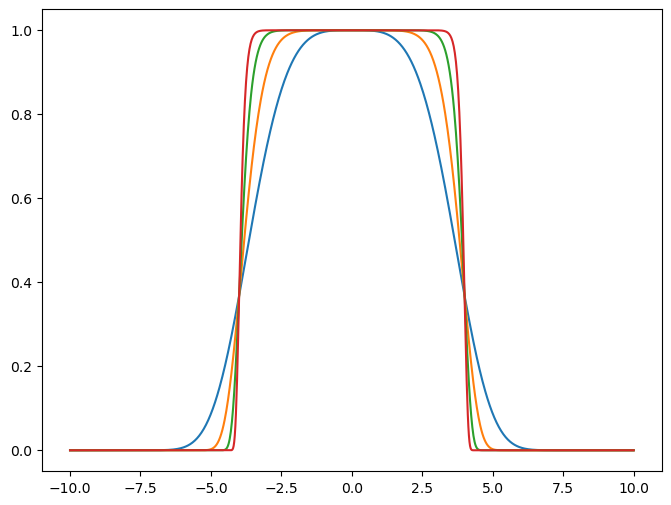

In [8]:
xx = np.linspace(-10,10,1000)

for order in [4, 8, 16, 32]:
    yy = resampler.super_gaussian(xx,sz=4,order=order)
    plt.plot(xx,yy)

(0.0, 100.0)

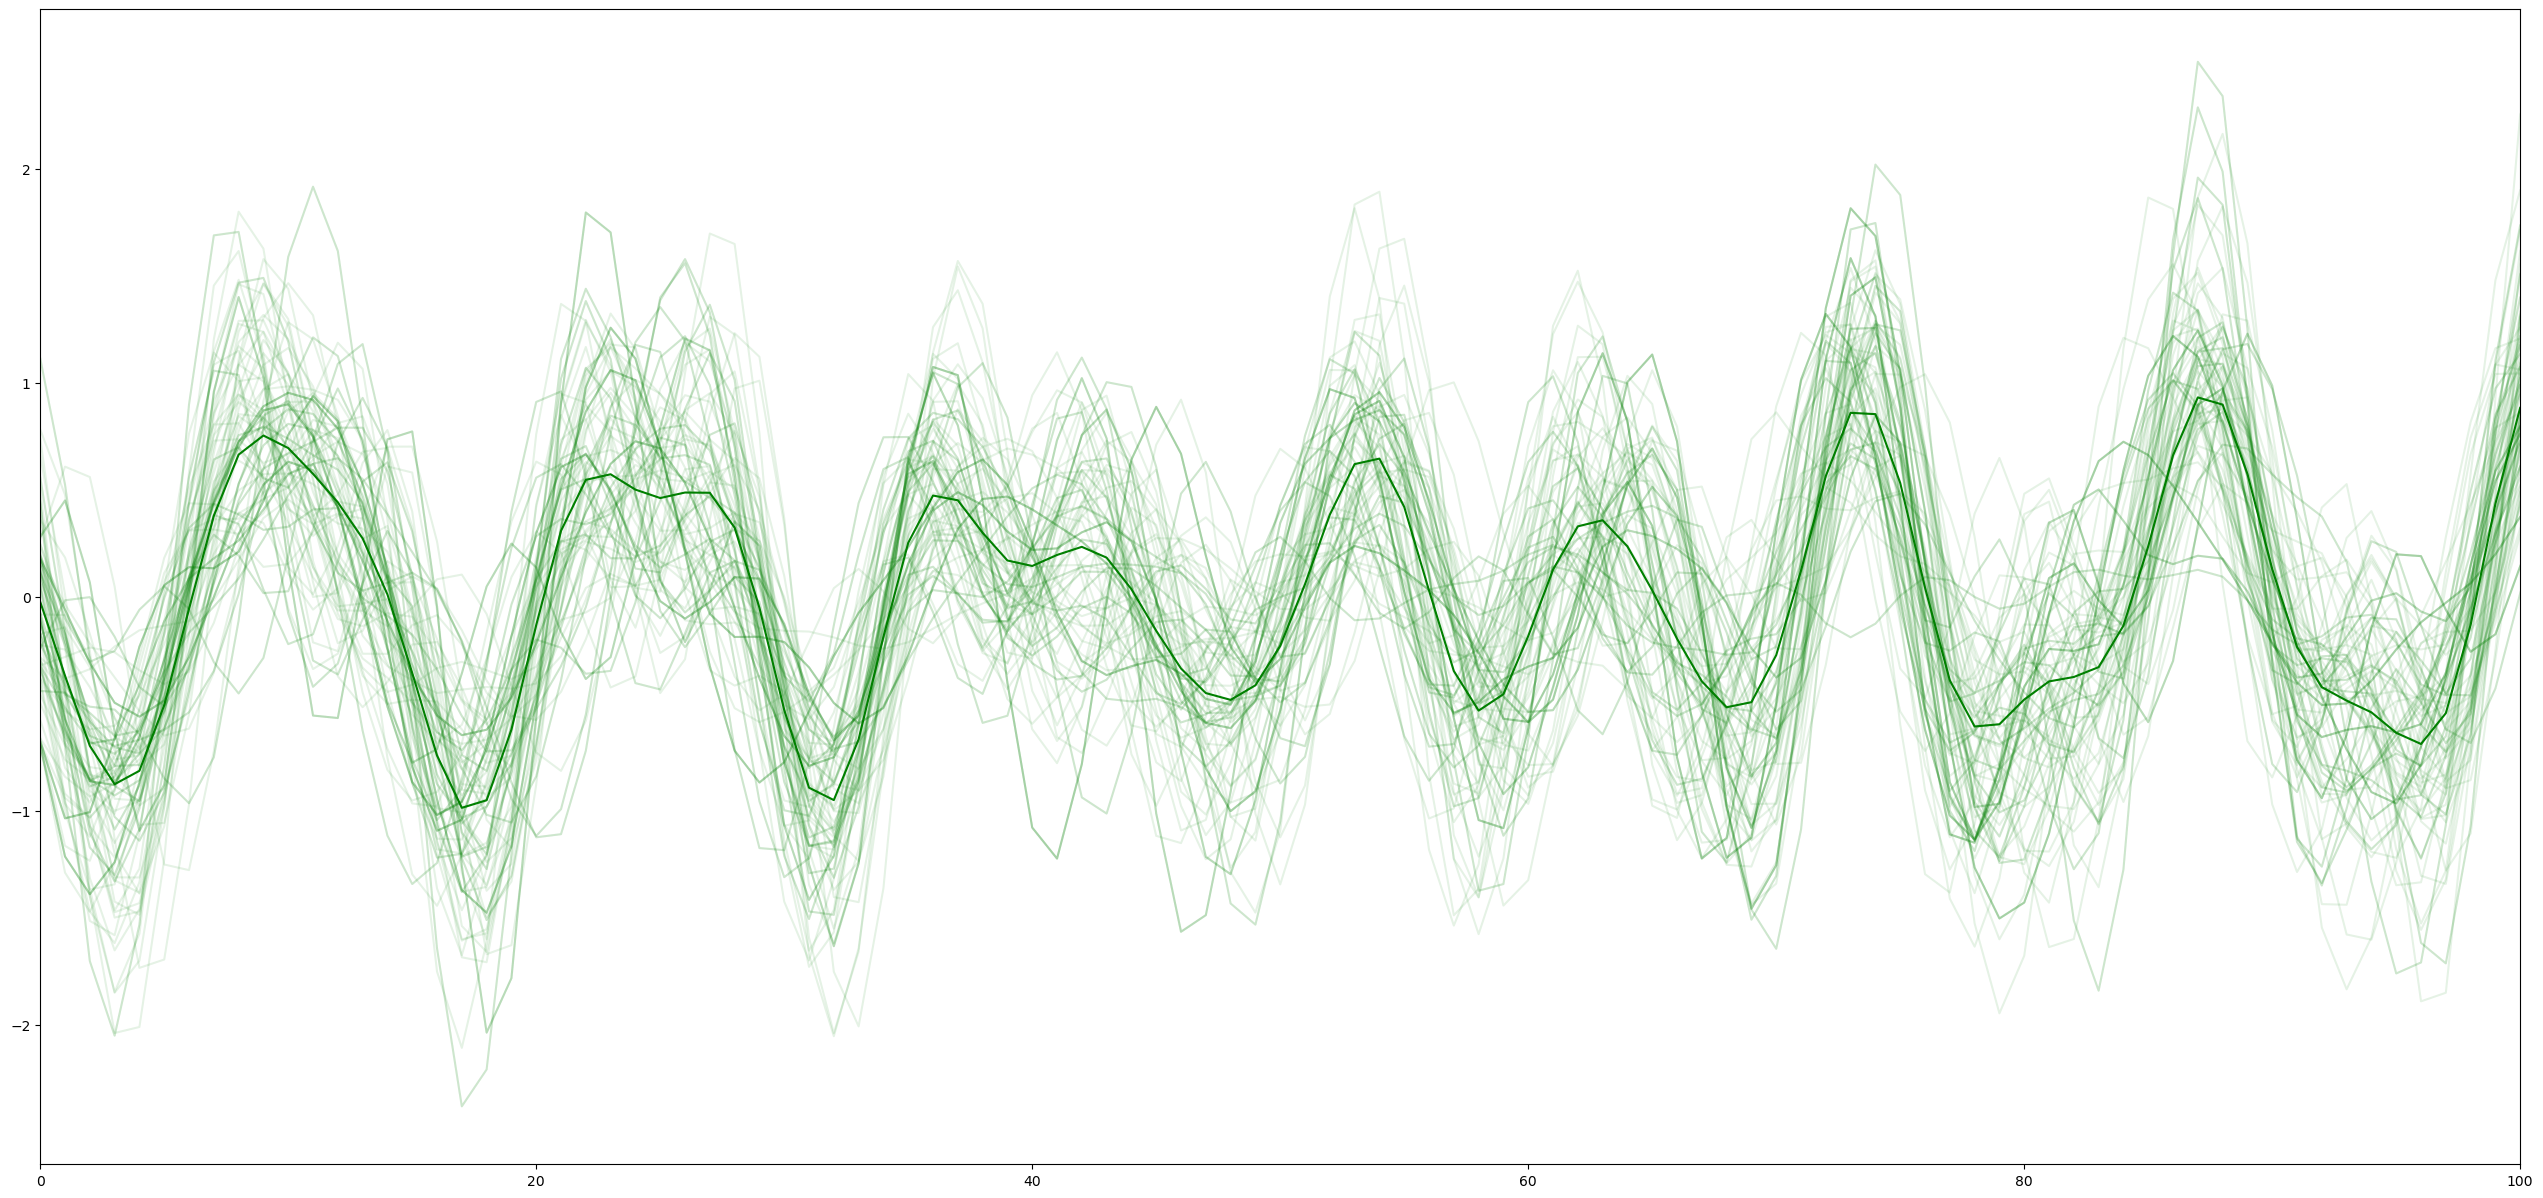

In [9]:
fig, axs = plt.subplots(1, figsize=(32, 15), sharex=True)
axs.plot(resampler.annual, sig, color="g")
for i in np.random.randint(100, size=100):
    axs.plot(resampler.annual, new_signal[i, :], color="g", alpha=0.1)

plt.xlim(0,100)
# axs.axvline(1520)
# axs.axvline(1540)
# axs.axvline(1560)
# axs.axvline(1580)
# axs.axvline(1600)

TypeError: 'int' object is not iterable

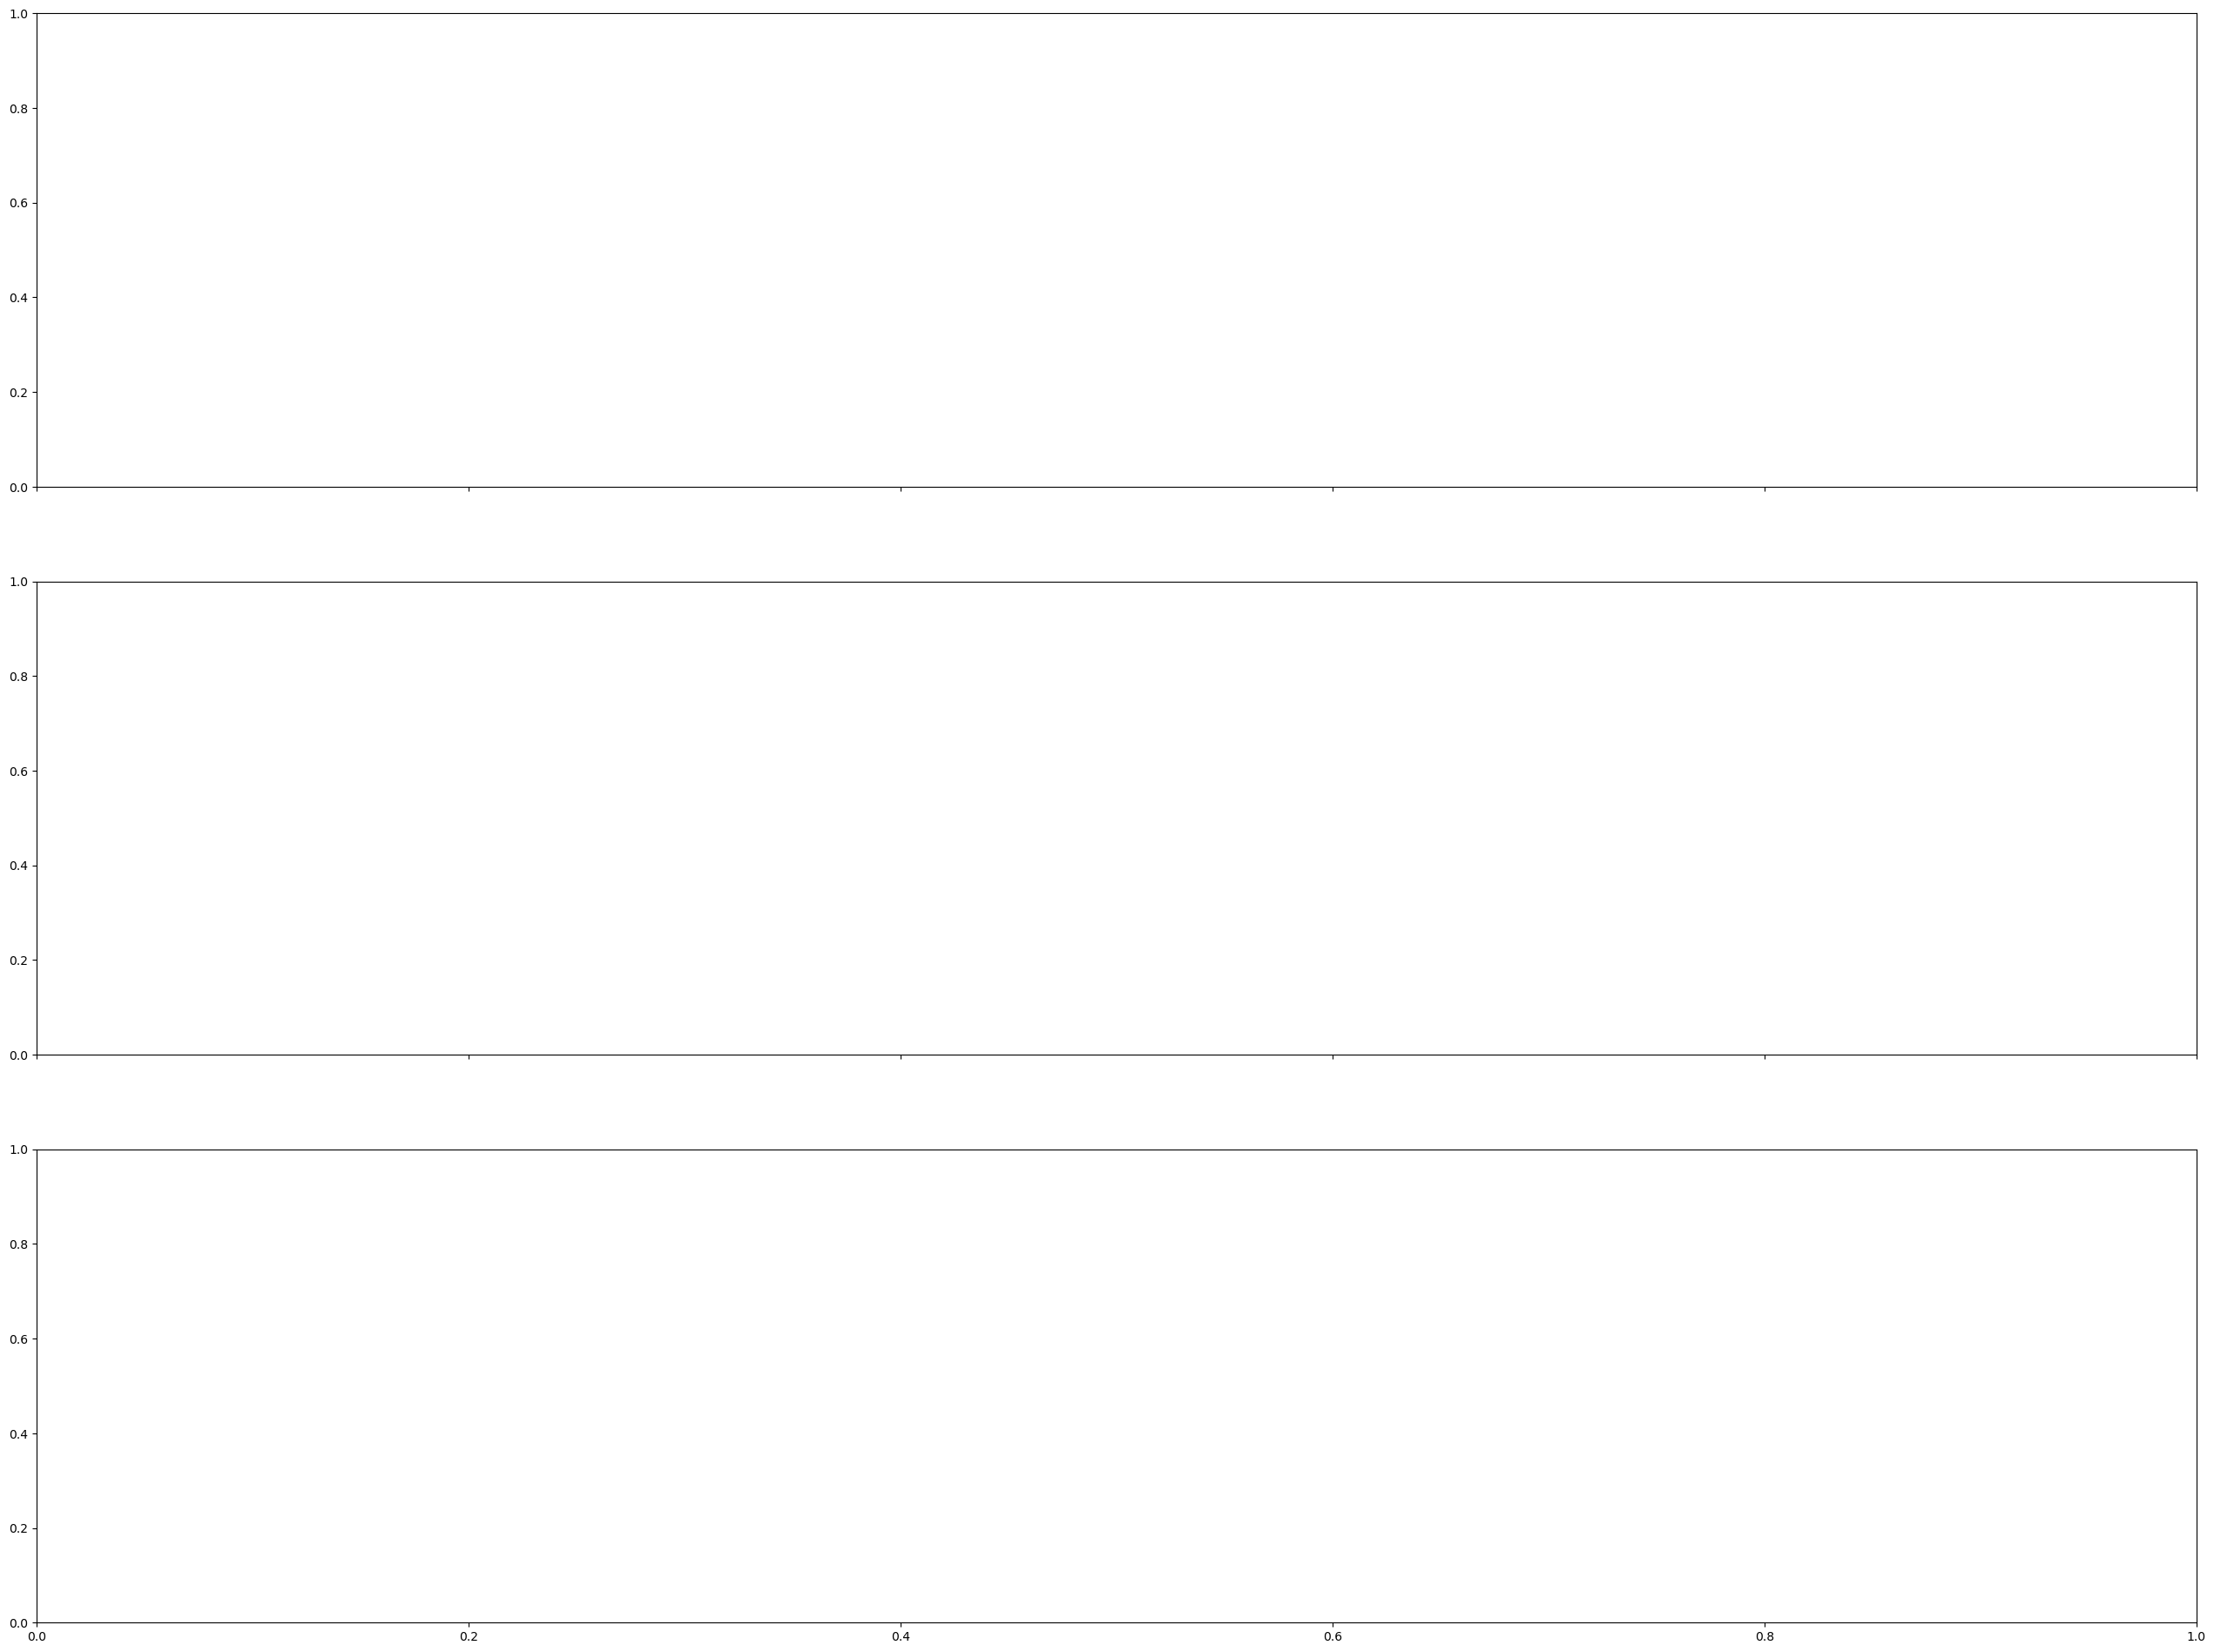

In [10]:
fig, axs = plt.subplots(3, figsize=(32, 24), sharex=True)
for i in np.random.choice(new_signal.shape[0]):
    axs[0].plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)
axs[0].plot(resampler.annual, sig, color="g")
axs[1].plot(resampler.annual, np.std(new_signal, axis=0))
l, m, u = np.percentile(new_signal, (2.5, 50, 97.5 ), axis=0)
axs[2].fill_between(resampler.annual, l, u, color = 'b', alpha=0.2)
axs[2].plot(resampler.annual, m, color = 'b')
print(new_signal)

[ 1.99216728e-18 -2.88549566e-18 -2.03569800e-18  2.70860808e-18
  8.97719399e-19 -3.45123236e-18  8.32640163e-19  2.21198927e-18
  3.95950633e-19 -5.25469425e-18 -5.11743425e-19 -1.68766910e-18
  3.80771803e-18 -1.04213513e-18  4.79098098e-18  1.11781244e-19
 -2.05082262e-18 -2.52293846e-18 -5.78963960e-19 -9.79305612e-19
 -3.51232715e-18 -9.16963987e-19  9.73179870e-19  2.50452057e-18
 -2.72850319e-18  3.01538308e-18 -2.63786389e-18  6.48352899e-20
 -2.09847330e-18 -2.20309881e-19 -1.36303187e-18 -1.70929894e-18
  7.02454588e-19  1.00624804e-18  1.95525020e-18  2.74975355e-18
 -5.91649126e-18 -1.18316273e-18 -4.27392496e-19  4.19342295e-18
 -2.78553222e-18  1.10669937e-18  1.09401420e-18 -4.19510347e-18
  1.15836160e-18  9.08832471e-19  3.63294464e-18  6.70036943e-19
 -5.06789977e-18 -4.11487251e-18  3.21650259e-18 -5.21268141e-18
  2.80298110e-18  2.88449277e-18 -3.67078330e-18 -6.98312935e-18
 -3.08206152e-18  5.62917768e-18  2.53546099e-18 -4.43698897e-18
 -2.42882971e-18 -5.22439

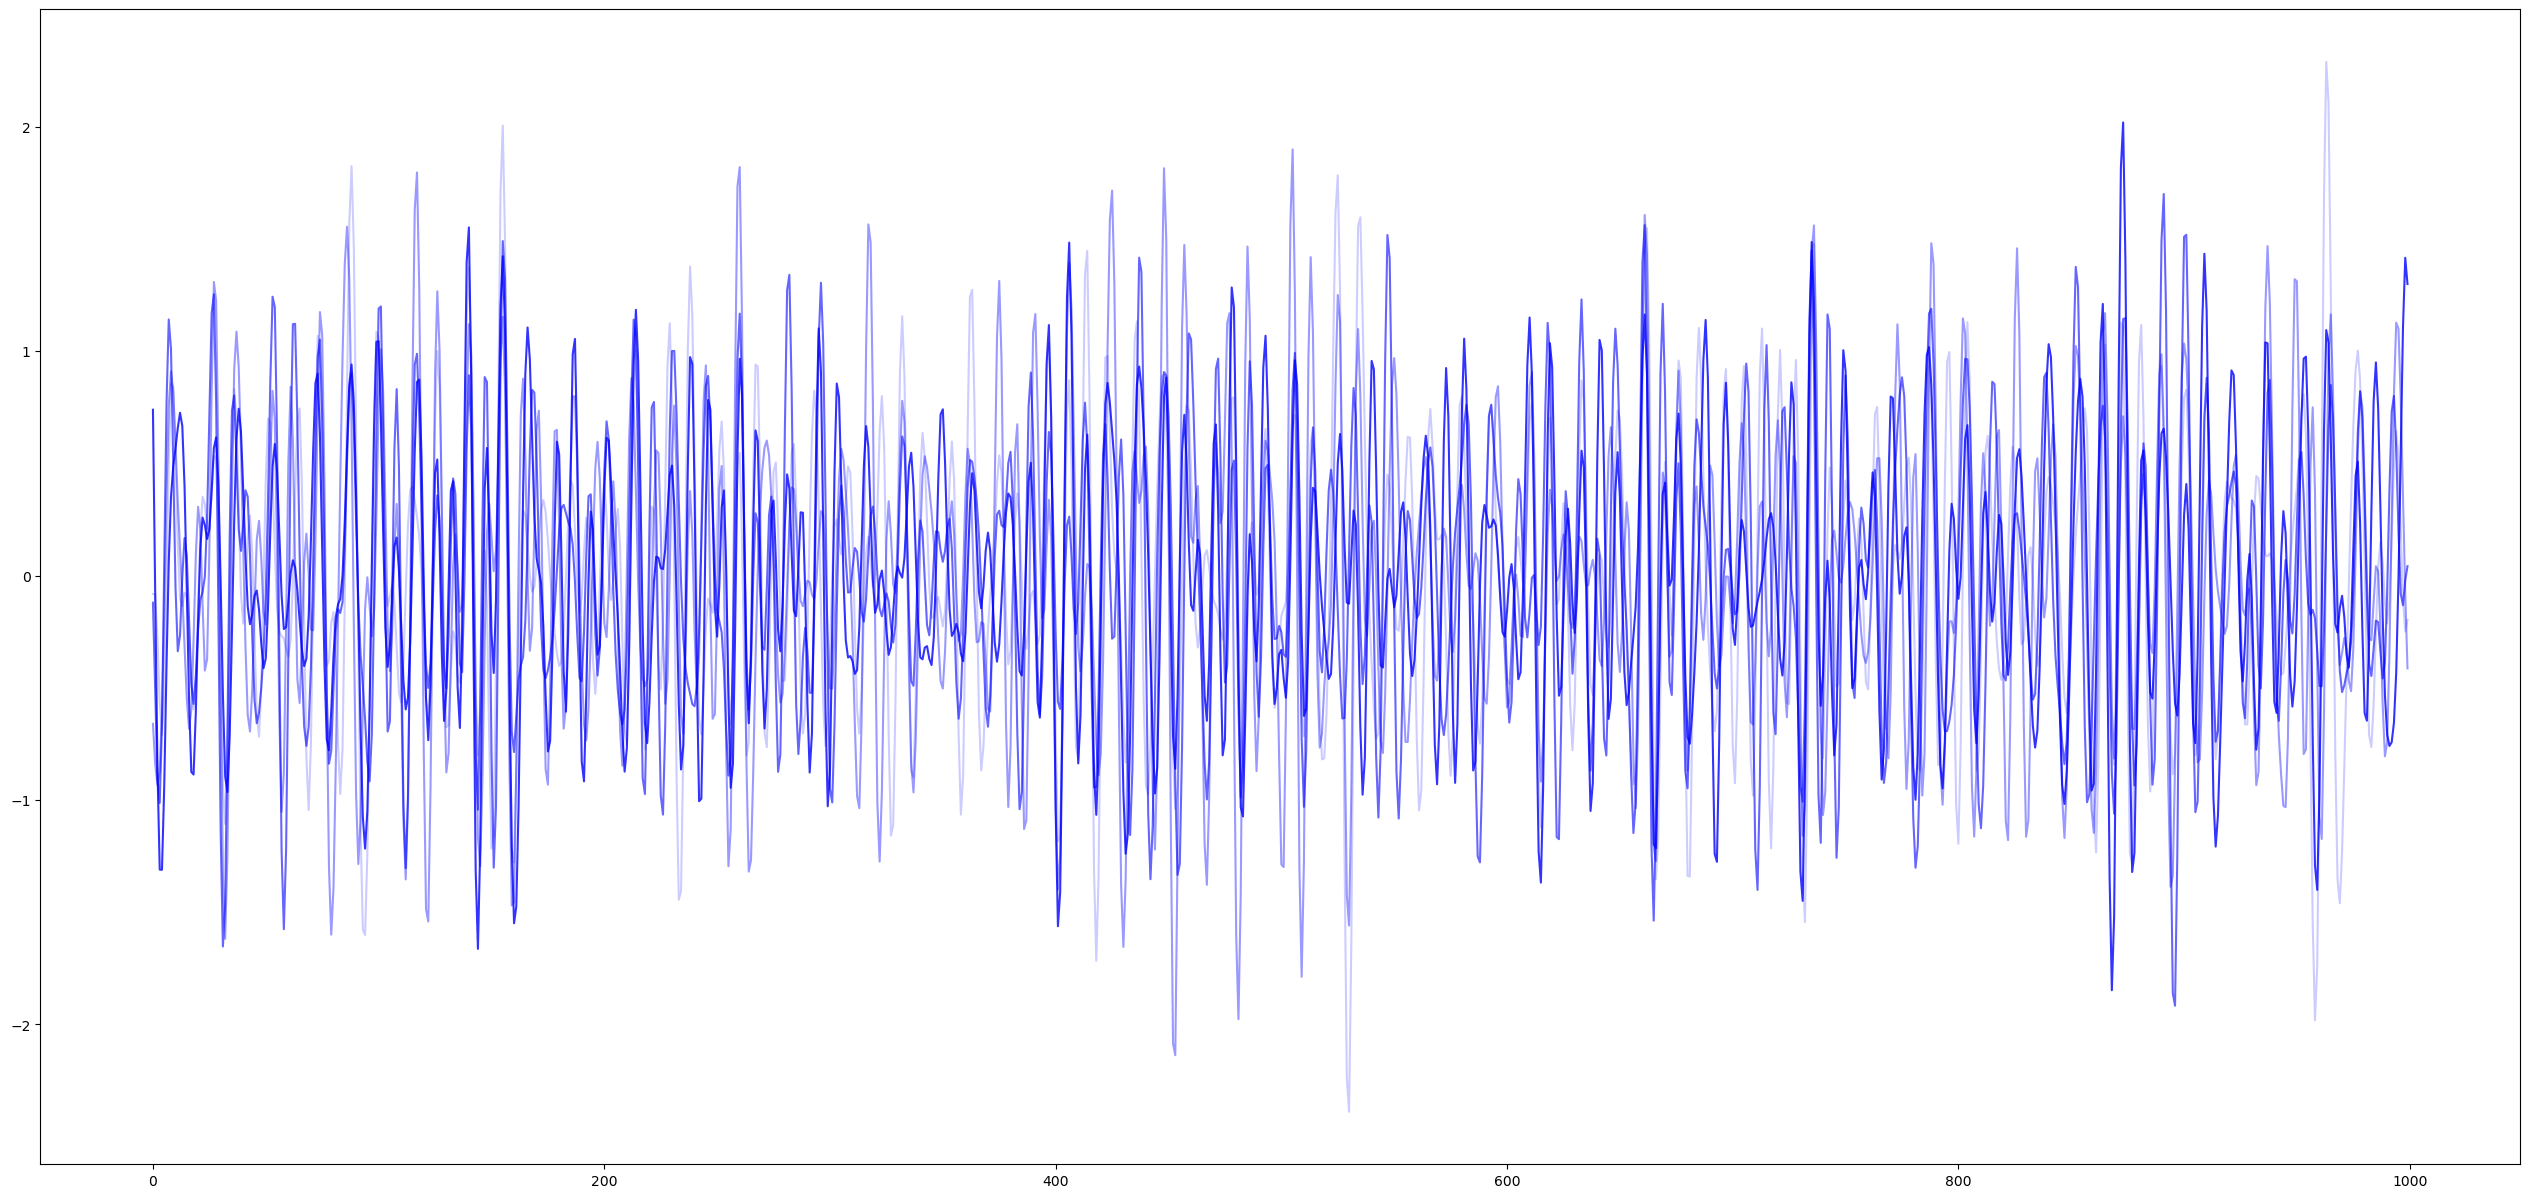

In [11]:
fig, axs = plt.subplots(1, figsize=(32, 15), sharex=True)
for i in range(5):
    axs.plot(resampler.annual,new_signal[i,:],color="b", alpha=0.2*i)
means = np.zeros(100)
zero_signal=new_signal
for i in range(100):
    means[i]=statistics.mean(new_signal[i,:])
    zero_signal[i,:]-=means[i]
print(means)
print(zero_signal.shape)

In [ ]:
%%time
norm_signal=zero_signal.copy()
for i in range(10000):
    norm_signal[i,:]=norm_signal[i,:]/np.sqrt((norm_signal[i,:]**2).sum())


CPU times: user 91 ms, sys: 50 μs, total: 91.1 ms
Wall time: 89 ms


In [ ]:
%%timeit 
sumy=0
for p in range(101):
    sumy+=float(new_signal[i,p])**2

34.8 μs ± 2.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit 
(new_signal[i,:]**2).sum()

3.69 μs ± 277 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
# interesting1 = norm_signal[0,:]
# dotprods=np.zeros(10000)
# newest=np.vstack([dotprods,dotprods,dotprods,dotprods,dotprods])
# for w in range(0,5):
#     recheck=np.zeros(10000)
#     interesting2=norm_signal[w,:]
#     for v in range(0,10000):
#         dotprod=0
#         for i in range(101):
#             dotprod+=interesting2[i]*norm_signal[v,i]
#         recheck[v]=dotprod
#     newest[w]=recheck
# print(newest)

In [ ]:
%%time
covmat = np.corrcoef(norm_signal)

CPU times: user 2.31 s, sys: 280 ms, total: 2.59 s
Wall time: 1.65 s


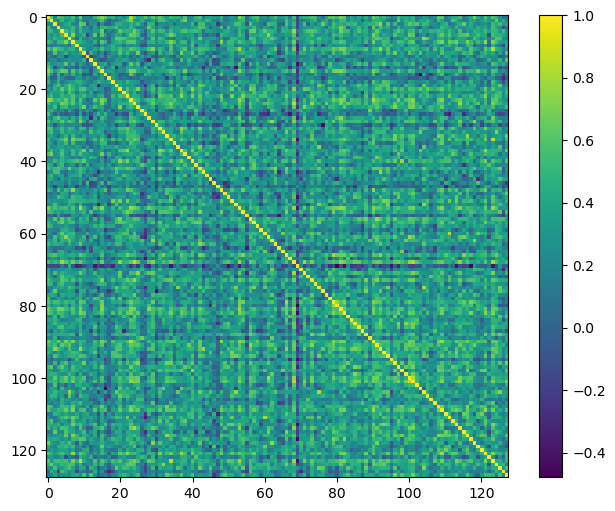

In [ ]:
plt.imshow(covmat[:128,:128])
plt.colorbar()

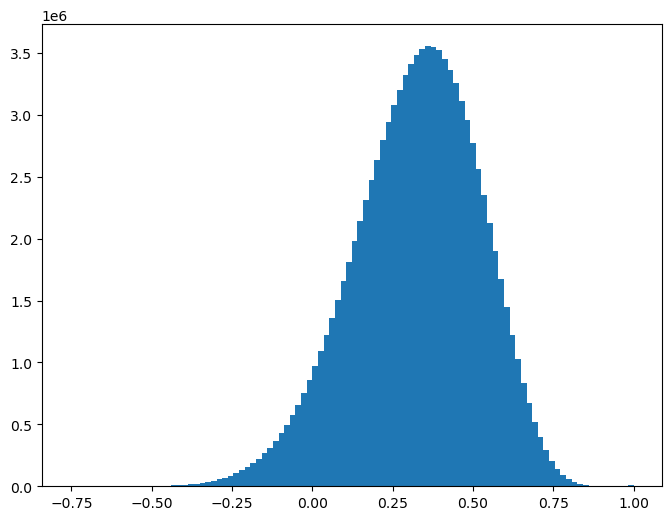

In [ ]:
plt.hist(covmat.ravel(),bins=100);